## Load libraries

In [1]:
pip install torch transformers

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import io
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import BertTokenizerFast, BertForTokenClassification
from transformers import pipeline
import torch

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Long Didlogue medical-NER

### Load dataset and experment on sub dataset

In [3]:
# Paths to the files
path_train_long = '/content/drive/MyDrive/W266_Project/Data/train_long.csv'

# Load the datasets
train_long = pd.read_csv(path_train_long)

# Check the first few rows to ensure they're loaded correctly
print("Long_dialogue_train_data:")
print(train_long.head())

# Check the shape
print("Shape of Long_dialogue_train_data:")
print(train_long.shape)

# Check the max word length of summary fot furture use
print("Max word length of summary:")
print(train_long['Note_Length'].max())

Long_dialogue_train_data:
                                            dialogue  \
0  doctor donna torres , date of birth , 08/01/19...   
1  doctor: Good morning, Mr. patient. I'm Dr. doc...   
2  doctor: Hello Mrs. patient, thank you for comi...   
3  doctor hi virginia how're you today patient i'...   
4  doctor: Hello, Mrs. patient, welcome back. How...   

                                                note  Dialogue_Length  \
0  SUBJECTIVE CHIEF COMPLAINT Annual health maint...             8595   
1  SUBJECTIVE CHIEF COMPLAINT Patient reports fru...             1760   
2  SUBJECTIVE CHIEF COMPLAINT Left arm pain after...             4074   
3  SUBJECTIVE CHIEF COMPLAINT Right knee pain. HI...             6728   
4  SUBJECTIVE CHIEF COMPLAINT Recurrent low back ...             1841   

   Note_Length  
0         2794  
1         1536  
2         2971  
3         2207  
4         1595  
Shape of Long_dialogue_train_data:
(1102, 4)
Max word length of summary:
4845


In [4]:
# find the dialogue with the longest summary to exam the extraction
# find the index of with the max note_length
max_note_length_index = train_long['Note_Length'].idxmax()

# Get the row with the maximum note_length
max_note_length_row = train_long.loc[max_note_length_index]

max_note_length_row

dialogue           doctor: Hello, Mrs. patient. I understand you ...
note               SUBJECTIVE CHIEF COMPLAINT Left shoulder and h...
Dialogue_Length                                                 3005
Note_Length                                                     4845
Name: 574, dtype: object

### medical_NER on long dialogue
- Just run NER on **summary** to identity which entities are most helpful
- model_max_length: 1000000000000000019884624838656, as the max lenggth in summary is 4845, set the max_lenght  to 15000 to save memory and run time



In [5]:
# Step 1: Load tokenizer and model for ClinicalBERT adapted for token classification
#model_name = "medicalai/ClinicalBERT"
model_name_medicalai_ClinicalBERT = "Clinical-AI-Apollo/Medical-NER"
tokenizer = AutoTokenizer.from_pretrained(model_name_medicalai_ClinicalBERT)
model = AutoModelForTokenClassification.from_pretrained(model_name_medicalai_ClinicalBERT)

# Step 2: Define Entity Extraction Function
def extract_entities_from_chunks(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True , truncation=True, max_length=15000)
    outputs = model(**inputs).logits
    predictions = torch.argmax(outputs, dim=2)
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0].tolist())
    labels = [model.config.id2label[prediction.item()] for prediction in predictions[0]]

    entities = []
    for token, label in zip(tokens, labels):
        if label != 'O' and token not in ['[CLS]', '[SEP]']:  # Exclude non-entity labels and special tokens
            entities.append({"token": token, "label": label})
    return entities

# Step 3:
train_long['summary_entities'] = train_long['note'].apply(lambda x: extract_entities_from_chunks(x))

# display a few rows
train_long.head(3)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,dialogue,note,Dialogue_Length,Note_Length,summary_entities
0,"doctor donna torres , date of birth , 08/01/19...",SUBJECTIVE CHIEF COMPLAINT Annual health maint...,8595,2794,"[{'token': '▁41', 'label': 'B-AGE'}, {'token':..."
1,"doctor: Good morning, Mr. patient. I'm Dr. doc...",SUBJECTIVE CHIEF COMPLAINT Patient reports fru...,1760,1536,"[{'token': '▁frustration', 'label': 'B-SIGN_SY..."
2,"doctor: Hello Mrs. patient, thank you for comi...",SUBJECTIVE CHIEF COMPLAINT Left arm pain after...,4074,2971,"[{'token': '▁arm', 'label': 'I-BIOLOGICAL_STRU..."


In [6]:
#diaplay medical entity for first 3 row of note_entities
for index, row in train_long.head(3).iterrows():
  print("dialogue", index)
  for entity in row['summary_entities']:
    print(entity)

dialogue 0
{'token': '▁41', 'label': 'B-AGE'}
{'token': '-', 'label': 'I-AGE'}
{'token': 'year', 'label': 'I-AGE'}
{'token': '-', 'label': 'I-AGE'}
{'token': 'old', 'label': 'I-AGE'}
{'token': '▁maintenance', 'label': 'I-DIAGNOSTIC_PROCEDURE'}
{'token': '▁anxiety', 'label': 'B-SIGN_SYMPTOM'}
{'token': '▁November', 'label': 'I-DURATION'}
{'token': '▁and', 'label': 'I-DURATION'}
{'token': '▁December', 'label': 'I-DURATION'}
{'token': '▁during', 'label': 'I-DETAILED_DESCRIPTION'}
{'token': '▁the', 'label': 'I-DETAILED_DESCRIPTION'}
{'token': '▁day', 'label': 'I-DETAILED_DESCRIPTION'}
{'token': '▁at', 'label': 'I-DETAILED_DESCRIPTION'}
{'token': '▁work', 'label': 'I-DETAILED_DESCRIPTION'}
{'token': '▁hearing', 'label': 'B-SIGN_SYMPTOM'}
{'token': '▁niacin', 'label': 'B-MEDICATION'}
{'token': '▁dyslipidemia', 'label': 'B-DISEASE_DISORDER'}
{'token': '▁hemorrhoids', 'label': 'B-SIGN_SYMPTOM'}
{'token': '▁last', 'label': 'I-DURATION'}
{'token': '▁6', 'label': 'I-DURATION'}
{'token': '▁months'

In [7]:
#diaplay medical entity for first 3 row of note_entities
for index, row in train_long.head(3).iterrows():
  print("dialogue", index)
  for entity in row['summary_entities']:
    print(entity)

dialogue 0
{'token': '▁41', 'label': 'B-AGE'}
{'token': '-', 'label': 'I-AGE'}
{'token': 'year', 'label': 'I-AGE'}
{'token': '-', 'label': 'I-AGE'}
{'token': 'old', 'label': 'I-AGE'}
{'token': '▁maintenance', 'label': 'I-DIAGNOSTIC_PROCEDURE'}
{'token': '▁anxiety', 'label': 'B-SIGN_SYMPTOM'}
{'token': '▁November', 'label': 'I-DURATION'}
{'token': '▁and', 'label': 'I-DURATION'}
{'token': '▁December', 'label': 'I-DURATION'}
{'token': '▁during', 'label': 'I-DETAILED_DESCRIPTION'}
{'token': '▁the', 'label': 'I-DETAILED_DESCRIPTION'}
{'token': '▁day', 'label': 'I-DETAILED_DESCRIPTION'}
{'token': '▁at', 'label': 'I-DETAILED_DESCRIPTION'}
{'token': '▁work', 'label': 'I-DETAILED_DESCRIPTION'}
{'token': '▁hearing', 'label': 'B-SIGN_SYMPTOM'}
{'token': '▁niacin', 'label': 'B-MEDICATION'}
{'token': '▁dyslipidemia', 'label': 'B-DISEASE_DISORDER'}
{'token': '▁hemorrhoids', 'label': 'B-SIGN_SYMPTOM'}
{'token': '▁last', 'label': 'I-DURATION'}
{'token': '▁6', 'label': 'I-DURATION'}
{'token': '▁months'

- From the output, we can tell this model use **SentencePiece** tokenlization: token starts with "_" indicates the start of new words or subwords and Tokens without the underscore are continuation tokens that are part of a word or subword unit.
This is different than the tokenization of **Bio-BERT diease** whcih using **wordPiecec**

#### Merge the tokens into words and conbine B and I lable with same entity

In [8]:
def merge_tokens_and_labels(token_label_pairs):
    merged_results = []
    current_phrase = ""
    current_label = ""

    # Handle the case where token_label_pairs might not be in the expected format
    if not isinstance(token_label_pairs, list) or not all(isinstance(item, dict) for item in token_label_pairs):
        return merged_results # Return empty list if format is unexpected

    for pair in token_label_pairs:
        # Check if keys exist before accessing them
        if 'token' in pair and 'label' in pair:
            token = pair['token']
            label = pair['label']

            # Remove the leading underscore if it exists
            if token.startswith('▁'):
                token = token[1:]

            # If the label starts with B, we start a new phrase
            if label.startswith('B-'):
                # If there's an existing phrase, add it to the results
                if current_phrase:
                    merged_results.append({'phrase': current_phrase, 'label': current_label})
                current_phrase = token
                current_label = label[2:]  # Remove the B- prefix
            elif label.startswith('I-') and label[2:] == current_label:
                # If the label is I- and matches the current entity type, continue the phrase
                current_phrase += " " + token
            else:
                # Handle case where I- doesn't match the current_label, which should be rare
                if current_phrase:
                    merged_results.append({'phrase': current_phrase, 'label': current_label})
                current_phrase = token
                current_label = label[2:]  # Use the new label
        else:
            print(f"Warning: Skipping pair due to missing keys: {pair}") # Alert the user about potential issues in the data

    # Add the last phrase if exists
    if current_phrase:
        merged_results.append({'phrase': current_phrase, 'label': current_label})

    return merged_results


#apply to the Apply batch processing to the dialogue columns of the subset
train_long['summary_entities_merged'] = train_long['summary_entities'].apply(lambda x: merge_tokens_and_labels(x))

#Check the result
train_long.head(3)

,dialogue,note,Dialogue_Length,Note_Length,summary_entities,summary_entities_merged
0,"doctor donna torres , date of birth , 08/01/19...",SUBJECTIVE CHIEF COMPLAINT Annual health maint...,8595,2794,"[{'token': '▁41', 'label': 'B-AGE'}, {'token':...","[{'phrase': '41 - year - old', 'label': 'AGE'}..."
1,"doctor: Good morning, Mr. patient. I'm Dr. doc...",SUBJECTIVE CHIEF COMPLAINT Patient reports fru...,1760,1536,"[{'token': '▁frustration', 'label': 'B-SIGN_SY...","[{'phrase': 'frustration', 'label': 'SIGN_SYMP..."
2,"doctor: Hello Mrs. patient, thank you for comi...",SUBJECTIVE CHIEF COMPLAINT Left arm pain after...,4074,2971,"[{'token': '▁arm', 'label': 'I-BIOLOGICAL_STRU...","[{'phrase': 'arm', 'label': 'BIOLOGICAL_STRUCT..."


### Count and plot the frequency of each label across the experiment data

In [9]:
# Function to count total label frequencies in the experiment dataset

from collections import Counter
def count_total_label_frequencies(data):
    all_labels = []
    for entities in data:
        labels = [entity['label'] for entity in entities]
        all_labels.extend(labels)
    return dict(Counter(all_labels))

# Count total frequencies
total_label_frequencies_long = count_total_label_frequencies(train_long['summary_entities_merged'])
sorted_frequencies_long = sorted(total_label_frequencies_long.items(), key=lambda item: item[1], reverse=True)
sorted_label_frequencies_long = dict(sorted_frequencies_long)
print(sorted_label_frequencies_long)

{'SIGN_SYMPTOM': 16875, 'BIOLOGICAL_STRUCTURE': 7674, 'DIAGNOSTIC_PROCEDURE': 7047, 'DISEASE_DISORDER': 6438, 'MEDICATION': 5388, 'DETAILED_DESCRIPTION': 4770, 'THERAPEUTIC_PROCEDURE': 3726, 'LAB_VALUE': 3335, 'CLINICAL_EVENT': 2532, 'DATE': 2452, 'NONBIOLOGICAL_LOCATION': 2189, 'DOSAGE': 1600, 'HISTORY': 1491, 'DURATION': 1490, 'AGE': 1256, 'SEX': 1015, 'SEVERITY': 644, 'FAMILY_HISTORY': 251, 'DISTANCE': 248, 'ADMINISTRATION': 56, 'AREA': 51, 'TIME': 12, 'VOLUME': 8, 'COREFERENCE': 3, 'PERSONAL_BACKGROUND': 1}


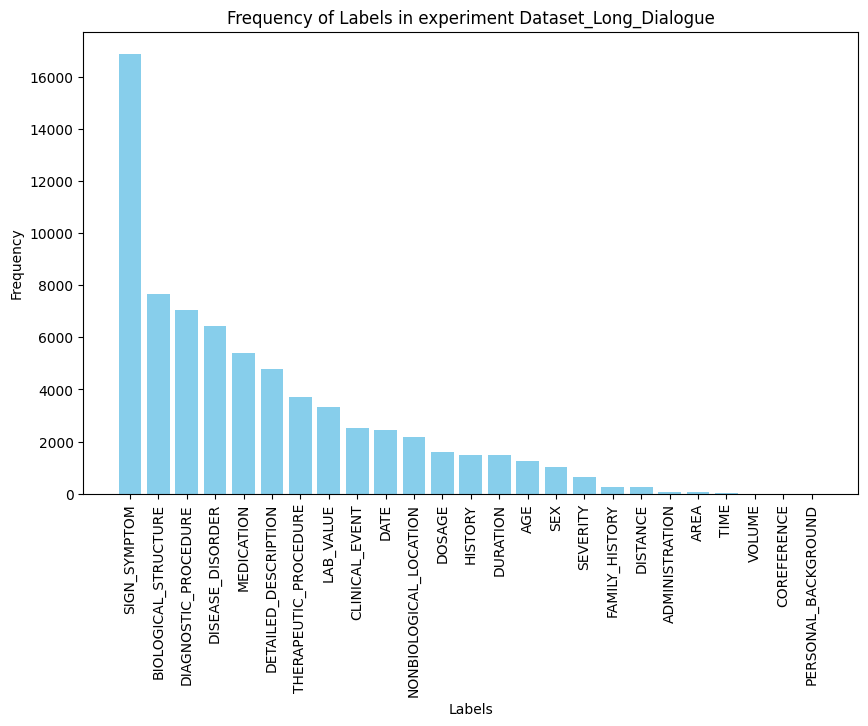

In [10]:
# Plot a bar chart
labels = list(sorted_label_frequencies_long.keys())
counts = list(sorted_label_frequencies_long.values())

plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Frequency of Labels in experiment Dataset_Long_Dialogue')
plt.xticks(rotation=90)
plt.show()

### Save extracted NER to new file

In [11]:
# Specify the directory to save the CSV files
output_dir = '/content/drive/MyDrive/W266_Project/Data'

# Ensure the directory exists
os.makedirs(output_dir, exist_ok=True)

# Save to CSV
train_long.to_csv(os.path.join(output_dir, 'train_long_medical_NER.csv'), index=False)

## Short Dialogue medical NER

### Load the data and experiment on the sub dataset

In [12]:
# Paths to the files
path_train_short = '/content/drive/MyDrive/W266_Project/Data/train_short.csv'

# Load the datasets
train_short = pd.read_csv(path_train_short)

# Check the first few rows to ensure they're loaded correctly
print("Short_dialogue_train_data:")
print(train_short.head())

# Check the shape
print("Shape of Short_dialogue_train_data:")
print(train_short.shape)

# Check the max word length of summary fot furture use
print("Max word length of summary:")
print(train_short['Summary_Length'].max())

Short_dialogue_train_data:
  section_header                                       section_text  \
0          GENHX  The patient is a 75-year-old female who comes ...   
1      FAM/SOCHX         Significant for diabetes and hypertension.   
2  PASTMEDICALHX                  Significant for anxiety disorder.   
3          GENHX  The patient is a 77-year-old female who is una...   
4      FAM/SOCHX                                   Noncontributory.   

                                            dialogue  Dialogue_Length  \
0  Doctor: Welcome to the clinic. I am Doctor Fra...             1396   
1  Doctor: Does anyone else in your family suffer...              175   
2  Doctor: Have we gone over your survey results ...              256   
3  Guest_clinician: How old is the patient? Docto...              438   
4  Doctor: Do you have a known- Patient: Drug all...              105   

   Summary_Length  
0             677  
1              42  
2              33  
3             325  
4      

In [13]:
# find the dialogue with the longest summary to exam the extraction
# find the index of with the max note_length
max_note_length_index = train_short['Summary_Length'].idxmax()

# Get the row with the maximum note_length
max_note_length_row = train_short.loc[max_note_length_index]

max_note_length_row

section_header                                                 GENHX
section_text       This is a 25-year-old woman who is attending p...
dialogue           Doctor: Hello, miss. Doctor X and I will be go...
Dialogue_Length                                                 8954
Summary_Length                                                  6237
Name: 1302, dtype: object

### Medical_NER on short dialogue
- Just run NER on **summary** to identity which entities are most helpful
- model_max_length: 1000000000000000019884624838656, as the max lenggth in summary is 6237, set the max_lenght  to 20000 to save memory and run time

In [14]:
# Step 1: Load tokenizer and model for ClinicalBERT adapted for token classification
#model_name = "medicalai/ClinicalBERT"
model_name_medicalai_ClinicalBERT = "Clinical-AI-Apollo/Medical-NER"
tokenizer = AutoTokenizer.from_pretrained(model_name_medicalai_ClinicalBERT)
model = AutoModelForTokenClassification.from_pretrained(model_name_medicalai_ClinicalBERT)

# Step 2: Define Entity Extraction Function
def extract_entities_from_chunks(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True , truncation=True, max_length=20000)
    outputs = model(**inputs).logits
    predictions = torch.argmax(outputs, dim=2)
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0].tolist())
    labels = [model.config.id2label[prediction.item()] for prediction in predictions[0]]

    entities = []
    for token, label in zip(tokens, labels):
        if label != 'O' and token not in ['[CLS]', '[SEP]']:  # Exclude non-entity labels and special tokens
            entities.append({"token": token, "label": label})
    return entities

# Step 3:
train_short['summary_entities'] = train_short['section_text'].apply(lambda x: extract_entities_from_chunks(x))

# display a few rows
train_short.head(3)


,section_header,section_text,dialogue,Dialogue_Length,Summary_Length,summary_entities
0,GENHX,The patient is a 75-year-old female who comes ...,Doctor: Welcome to the clinic. I am Doctor Fra...,1396,677,"[{'token': '▁75', 'label': 'B-AGE'}, {'token':..."
1,FAM/SOCHX,Significant for diabetes and hypertension.,Doctor: Does anyone else in your family suffer...,175,42,"[{'token': '▁diabetes', 'label': 'B-DISEASE_DI..."
2,PASTMEDICALHX,Significant for anxiety disorder.,Doctor: Have we gone over your survey results ...,256,33,"[{'token': '▁anxiety', 'label': 'B-DISEASE_DIS..."


In [15]:
#diaplay medical entity for first 3 row of note_entities
for index, row in train_short.head(3).iterrows():
  print("dialogue", index)
  for entity in row['summary_entities']:
    print(entity)

dialogue 0
{'token': '▁75', 'label': 'B-AGE'}
{'token': '-', 'label': 'I-AGE'}
{'token': 'year', 'label': 'I-AGE'}
{'token': '-', 'label': 'I-AGE'}
{'token': 'old', 'label': 'I-AGE'}
{'token': '▁female', 'label': 'B-SEX'}
{'token': '▁stroke', 'label': 'B-DISEASE_DISORDER'}
{'token': '▁throat', 'label': 'B-BIOLOGICAL_STRUCTURE'}
{'token': '▁dizziness', 'label': 'B-SIGN_SYMPTOM'}
{'token': '▁morning', 'label': 'I-DATE'}
{'token': '▁left', 'label': 'B-BIOLOGICAL_STRUCTURE'}
{'token': '▁hand', 'label': 'I-BIOLOGICAL_STRUCTURE'}
{'token': '▁left', 'label': 'B-BIOLOGICAL_STRUCTURE'}
{'token': '▁jaw', 'label': 'I-BIOLOGICAL_STRUCTURE'}
{'token': '▁numbness', 'label': 'B-SIGN_SYMPTOM'}
{'token': '▁three', 'label': 'B-DURATION'}
{'token': '▁weeks', 'label': 'I-DURATION'}
{'token': '▁ago', 'label': 'I-DATE'}
{'token': '▁dizzy', 'label': 'B-SIGN_SYMPTOM'}
{'token': '▁falling', 'label': 'B-SIGN_SYMPTOM'}
{'token': '▁down', 'label': 'I-HISTORY'}
{'token': '▁Dr', 'label': 'B-NONBIOLOGICAL_LOCATION'}

In [16]:
#apply to the Apply batch processing to the dialogue columns of the subset
train_short['summary_entities_merged'] = train_short['summary_entities'].apply(lambda x: merge_tokens_and_labels(x))

#Check the result
train_short.head(3)

,section_header,section_text,dialogue,Dialogue_Length,Summary_Length,summary_entities,summary_entities_merged
0,GENHX,The patient is a 75-year-old female who comes ...,Doctor: Welcome to the clinic. I am Doctor Fra...,1396,677,"[{'token': '▁75', 'label': 'B-AGE'}, {'token':...","[{'phrase': '75 - year - old', 'label': 'AGE'}..."
1,FAM/SOCHX,Significant for diabetes and hypertension.,Doctor: Does anyone else in your family suffer...,175,42,"[{'token': '▁diabetes', 'label': 'B-DISEASE_DI...","[{'phrase': 'diabetes', 'label': 'DISEASE_DISO..."
2,PASTMEDICALHX,Significant for anxiety disorder.,Doctor: Have we gone over your survey results ...,256,33,"[{'token': '▁anxiety', 'label': 'B-DISEASE_DIS...","[{'phrase': 'anxiety disorder', 'label': 'DISE..."


### Count and plot the frequency of each label across the experiment data

In [17]:
total_label_frequencies_short = count_total_label_frequencies(train_short['summary_entities_merged'])
sorted_frequencies_short = sorted(total_label_frequencies_short.items(), key=lambda item: item[1], reverse=True)
sorted_label_frequencies_short = dict(sorted_frequencies_short)
print(sorted_label_frequencies_short)

{'SIGN_SYMPTOM': 2621, 'BIOLOGICAL_STRUCTURE': 1399, 'DETAILED_DESCRIPTION': 1272, 'DISEASE_DISORDER': 1227, 'HISTORY': 795, 'DIAGNOSTIC_PROCEDURE': 694, 'THERAPEUTIC_PROCEDURE': 587, 'DATE': 562, 'MEDICATION': 513, 'LAB_VALUE': 511, 'NONBIOLOGICAL_LOCATION': 418, 'CLINICAL_EVENT': 396, 'DURATION': 354, 'AGE': 283, 'FAMILY_HISTORY': 211, 'SEX': 188, 'DOSAGE': 175, 'SEVERITY': 107, 'DISTANCE': 47, 'PERSONAL_BACKGROUND': 40, 'AREA': 27, 'ADMINISTRATION': 6, 'TEXTURE': 1, 'COREFERENCE': 1, 'VOLUME': 1, 'TIME': 1}


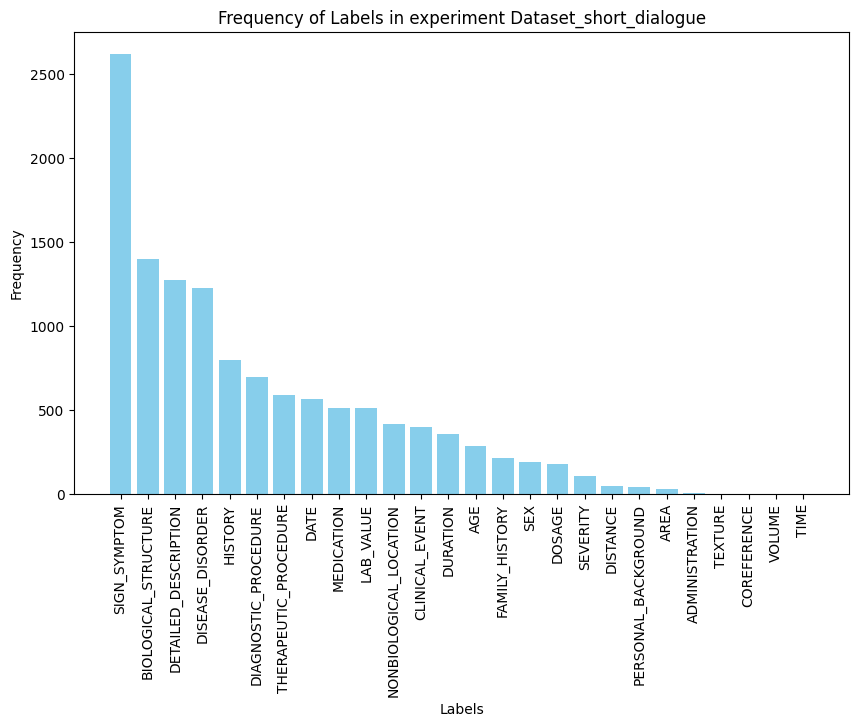

In [18]:
# Plot a bar chart
labels = list(sorted_label_frequencies_short.keys())
counts = list(sorted_label_frequencies_short.values())

plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Frequency of Labels in experiment Dataset_short_dialogue')
plt.xticks(rotation=90)
plt.show()

### Save extracted NER to new file

In [19]:
# Specify the directory to save the CSV files
output_dir = '/content/drive/MyDrive/W266_Project/Data'

# Ensure the directory exists
os.makedirs(output_dir, exist_ok=True)

# Save to CSV
train_short.to_csv(os.path.join(output_dir, 'train_short_medical_NER.csv'), index=False)